In [ ]:
import time
import torch
import torchvision
import torch.nn as nn
import torch.optim as optim
from torchvision import transforms, datasets
from torch.utils.data import DataLoader
from torch.utils.tensorboard import SummaryWriter
from sklearn.decomposition import PCA
from matplotlib import cm
from sklearn.manifold import TSNE
from sklearn.metrics import confusion_matrix
import torchvision.models as models
from torchvision.models import resnet18, ResNet18_Weights
from sklearn.metrics import *
import seaborn as sns
import os
import seaborn
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from pathlib import Path
import os.path
import random
import cv2


In [ ]:
writer = SummaryWriter()
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")


from google.colab import drive
drive.mount('/content/gdrive/');

# import torch

# # Initialize the CUDA context
# torch.cuda.init()

# # # Create a cuBLAS handle
# # cublas_handle = torch.cuda.cublas.create_handle()
# device_id = 0
# with torch.cuda.device(device_id):
#     # Create a cuBLAS handle
#     cublas_handle = torch.cuda.cublas.create_handle()

os.environ['CUDA_LAUNCH_BLOCKING'] = "1"

transforms_train = transforms.Compose([
    transforms.Resize((256, 256)),   #must same as here
    transforms.RandomResizedCrop(224),
    transforms.RandomHorizontalFlip(), # data augmentation
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225]) # normalization
])
transforms_test = transforms.Compose([
    transforms.Resize((224, 224)),   #must same as here
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])



Drive already mounted at /content/gdrive/; to attempt to forcibly remount, call drive.mount("/content/gdrive/", force_remount=True).


In [ ]:
def load_Data():
  train_dir = "/content/gdrive/MyDrive/Final_Dataset/dataset2/train"
  test_dir = "/content/gdrive/MyDrive/Final_Dataset/dataset2/test"
  val_dir = "/content/gdrive/MyDrive/Final_Dataset/dataset2/val"
  # train_dir = "/content/gdrive/MyDrive/test/dataset1/train"
  # test_dir = "/content/gdrive/MyDrive/test/dataset1/test"
  # val_dir = "/content/gdrive/MyDrive/test/dataset1/val"
  trainset = datasets.ImageFolder(train_dir, transforms_train)
  testset = datasets.ImageFolder(test_dir, transforms_test)
  valset = datasets.ImageFolder(val_dir, transforms_test)
  trainloader = torch.utils.data.DataLoader(trainset, batch_size=32, shuffle=True, num_workers=8)
  testloader = torch.utils.data.DataLoader(testset, batch_size=32, shuffle=False, num_workers=8)
  valloader = torch.utils.data.DataLoader(valset, batch_size=32, shuffle=False, num_workers=8)
  return trainloader,testloader,valloader
load_Data()

/usr/local/lib/python3.9/dist-packages/torch/utils/data/dataloader.py:554: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


(<torch.utils.data.dataloader.DataLoader at 0x7f47447cbd00>,
 <torch.utils.data.dataloader.DataLoader at 0x7f47447cbc70>)

In [ ]:
# def Model():
#   # Define the ResNet-18 model
#   resnet = 
#   # Replace the last fully connected layer with a new one
#   num_ftrs = resnet.fc.in_features
#   print(num_ftrs)
#   resnet.fc = nn.Linear(num_ftrs,2)

#   # Define the loss function and optimizer
#   return resnet
# Model()


In [ ]:
class Resnet18(nn.Module):
    def __init__(self,inputDims) -> None:
        super(Resnet18 , self).__init__()

        self.model = torchvision.models.resnet18(pretrained=False)

        self.fc_layer = nn.Sequential(
            
            nn.Linear(512, 256),
            nn.ReLU(inplace=True),
            nn.Dropout(p=0.2),

            nn.Linear(256, 128),
            nn.ReLU(inplace=True),
            nn.Dropout(p=0.2),

            nn.Linear(128, 64),
            nn.ReLU(inplace=True),
            nn.Dropout(p=0.2),

            nn.Linear(64, 32),
            nn.ReLU(inplace=True),
            nn.Dropout(p=0.2),

            nn.Linear(32, 5)
        )
        
        self.model.fc = self.fc_layer
        self.features = {}
        self.model.avgpool.register_forward_hook(self.get_features("embeddings"))

    def get_features(self,name):
        def hook(model, input, output):
            self.features[name] = output.detach().cpu().numpy()
        return hook

    def forward(self, x):
          x = self.model(x)
          return x
model2 = Resnet18((224,224))
print(model2)


Resnet18(
  (model): ResNet(
    (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU(inplace=True)
    (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (layer1): Sequential(
      (0): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
      (1): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_runn

/usr/local/lib/python3.9/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=None`.
  warnings.warn(msg)


In [ ]:
def save_checkpoint(state, filename):
  torch.save(state, filename)


In [ ]:
# datastructure to store all the training testing and validation results.
y_train = []
y_expected_train = []
y_val = []
y_expected_val = []
y_test = []
y_expected_test = []
trainloss = []
valloss =[]
epochnum = []  

In [ ]:
print(torch.cuda.is_available())
def train(model, train_loader, criterion, optimizer, epoch, step=5):
    
    model.train()
    for i, (images, labels) in enumerate(train_loader):
        #print(torch.cuda.is_available())
        total =0
        correct = 0
        if torch.cuda.is_available():
            images = images.cuda()
            labels = labels.cuda()

            print(images.size)
            print(labels.size)
        #print(predicted,type(predicted))
        #print(labels,type(labels))
        output = model(images)
        loss = criterion(output,labels)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        _, predicted = torch.max(output.data, 1)
        y_train.extend(predicted.to(torch.device('cpu')))
        y_expected_train.extend(labels.to(torch.device('cpu')))
        total += labels.size(0)
        correct += (predicted == labels).sum().item()
        accuracy = 100 * correct / total
        #print( f'Training Accuracy: {accuracy:.2f}%')
            
        if i%step==0:
            print('EPOCH {} | ITER {} | AVG_LOSS {} | Train_ACC {}'.format(epoch, i, loss,accuracy))
        writer.add_scalar('TRAIN_LOSS', loss, epoch)
        
    return loss ,accuracy

True


In [ ]:
def test(resnet, testloader, criterion, optimizer, epoch,step=5):
  with torch.no_grad():
        correct = 0
        total = 0
        for inputs, labels in testloader:
            inputs = inputs.to(device)
            #print(inputs.shape)
            #print(labels.shape)
            labels = labels.to(device)
            outputs = resnet(inputs)
            
            _, predicted = torch.max(outputs.data, 1)
            #print(predicted,type(predicted))
            #print(labels,type(labels))
            y_val.extend(predicted.to(torch.device('cpu')))
            y_expected_val.extend(labels.to(torch.device('cpu')))
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
            accuracy = 100 * correct / total
            print(f'Test Accuracy: {accuracy:.2f}%')
            return accuracy


In [ ]:
def val(model, val_loader, criterion, optimizer, epoch, step=5):
    model.eval()
    with torch.no_grad():
        correct = 0
        total = 0
        for inputs, labels in val_loader:
            inputs = inputs.to(device)
            #print("Inside validation");
            #print(inputs.shape)
            #print(labels.shape)
            labels = labels.to(device)
            outputs = model(inputs)
            
            _, predicted = torch.max(outputs.data, 1)
            #print(predicted,type(predicted))
            #print(labels,type(labels))
            loss = criterion(outputs,labels)
            y_val.extend(predicted.to(torch.device('cpu')))
            y_expected_val.extend(labels.to(torch.device('cpu')))
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
            #print("CORRECT",correct)
            #print("Total",total)
        accuracy = 100 * correct / total
        print(f'Val Accuracy: {accuracy:.2f}%')
        return loss,accuracy

In [ ]:
def test(model, test_loader, criterion, optimizer, epoch, step=5):
    model.eval()
    with torch.no_grad():
        correct = 0
        total = 0
        print("*"*40)
        for inputs, labels in test_loader:
            inputs = inputs.to(device)
            
            #print("Inside test");
            #print(inputs.shape)
            #print(labels.shape)
            labels = labels.to(device)
            outputs = model(inputs)
            
            _, predicted = torch.max(outputs.data, 1)
            #print(predicted,type(predicted))
            #print(labels,type(labels))
            y_test.extend(predicted.to(torch.device('cpu')))
            y_expected_test.extend(labels.to(torch.device('cpu')))
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
        accuracy = 100 * correct / total
        print(f'test Accuracy: {accuracy:.2f}%')
        return accuracy

In [ ]:
def visualize(model , data_loader):
    class2idx = {'cat': 0, 'cow': 1, 'dog': 2, 'elephant': 3, 'horse': 4}
    idx2class = { value : key for key,value in  class2idx.items() }
    embeddings = np.array([])
    labels = np.array([])
    model.eval()
    out_features = 512
    num_categories = 5
    with torch.no_grad(): 
        for i,data in enumerate(data_loader):
            images, labs = data[0].to(device), data[1].to(device)
            outputs = model(images)
            _, predicted = torch.max(outputs.data, 1)
            embeds = model.features["embeddings"].reshape(-1, 512)
            embeddings = np.append(embeddings , embeds)
            labels = np.append(labels,labs.cpu())
  
    embeddings = embeddings.reshape(-1, 512)
    
    c_labels = labels.reshape(-1 , 1).ravel()
    tsne = TSNE(n_components=2,perplexity=2).fit_transform(embeddings)
    labels = np.array([ idx2class[ele] for ele in c_labels])
    
    cmap = cm.get_cmap('tab20')
    
    for lab in range(num_categories):
        indices = (c_labels == lab)
        plt.scatter(tsne[indices, 0],tsne[indices, 1],c=np.array(cmap(lab)).reshape(1, 4),label=lab,alpha=1)
        plt.legend(fontsize='large', markerscale=2)
    plt.show()
  
# model = Model((224,224))
# train_loader, val_loader ,test_loader = load_Data()
# visualize(model,test_loader)


In [ ]:
def plotloss():
  plt.figure(figsize=(20,10))
  plt.plot(epochnum, trainloss)
  plt.plot(epochnum, valloss)
  plt.xlabel('epoch')
  plt.ylabel('loss')
  plt.legend(['training', 'validation'], loc='upper right')
  plt.show()


In [ ]:
class2idx = {'cat': 0, 'cow': 1, 'dog': 2, 'elephant': 3, 'horse': 4}
idx2class = { value : key  for key , value in class2idx.items() }

def plot_confusion_matrix(data, labels, metrics ,output_filename=None):

    [macro_precision , micro_precision , macro_recall , micro_recall] = metrics

    seaborn.set(color_codes=True)
    plt.figure(1, figsize=(10,10))
 
    plt.suptitle("Confusion Matrix")
    plt.title(f"(Macro/Micro) Precision : {round(macro_precision,2)}/{round(micro_precision,2)}   :::::   (Macro/Micro) Recall : {round(macro_recall,2)}/{round(micro_recall,2)}")
 
    seaborn.set(font_scale=1)
    ax = seaborn.heatmap(data, annot=True, cmap="YlGnBu",linewidths=2 , fmt='d' ,cbar_kws={'label': 'Scale'})
 
    ax.set_xticklabels(labels)
    ax.set_yticklabels(labels)
 
    ax.set(ylabel="True Label", xlabel="Predicted Label")
    
    plt.savefig(output_filename, bbox_inches='tight', dpi=300)
    plt.show()
    plt.close()



Streaming output truncated to the last 5000 lines.
<built-in method size of Tensor object at 0x7f4740a03360>
<built-in method size of Tensor object at 0x7f4740d4a9a0>
EPOCH 21 | ITER 10 | AVG_LOSS 0.7013779878616333 | Train_ACC 78.125
<built-in method size of Tensor object at 0x7f4740a104f0>
<built-in method size of Tensor object at 0x7f4740a03360>
<built-in method size of Tensor object at 0x7f4740a104f0>
<built-in method size of Tensor object at 0x7f4740a03360>
<built-in method size of Tensor object at 0x7f4740a03360>
<built-in method size of Tensor object at 0x7f4740a104f0>
<built-in method size of Tensor object at 0x7f4740a03360>
<built-in method size of Tensor object at 0x7f4740a104f0>
<built-in method size of Tensor object at 0x7f4740a104f0>
<built-in method size of Tensor object at 0x7f4740a03360>
EPOCH 21 | ITER 15 | AVG_LOSS 1.0993237495422363 | Train_ACC 46.875
<built-in method size of Tensor object at 0x7f4740a03360>
<built-in method size of Tensor object at 0x7f4740a104f0>
<

<ipython-input-44-f4e55a233ef4>:24: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = cm.get_cmap('tab20')


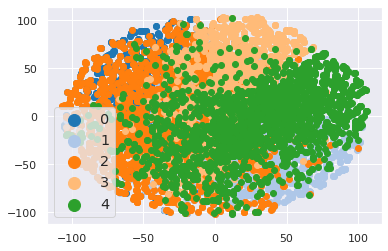

In [47]:
def main():
    model = Resnet18((224,224));
    print(torch.cuda.is_available())
    if torch.cuda.is_available():
      model = model.cuda()
      print("using gpu")

    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.parameters(), lr=0.001)
    epochs = 30
    train_loader, val_loader ,test_loader = load_Data()
 
    history = open("/content/gdrive/MyDrive/Results/dataset2_Resnet18_history.csv",'w')
    history.write('epochs , trainloss , Train-acc,val_acc , test_acc \n')
    max_accuracy = 0 
    for epoch in range(0,epochs):
        start = time.time()
        train_loss,accuracy = train(model, train_loader, criterion, optimizer, epoch)
        vallosss,val_loss = val(model, val_loader, criterion, optimizer, epoch)
        test_loss = test(model, test_loader, criterion, optimizer, epoch)
        trainloss.append(train_loss.cpu().detach().numpy())
        valloss.append(vallosss.cpu().detach().numpy())
        epochnum.append(epoch)
        print()
        print('-' * 50)
        print('EPOCH {} | LOSS {} | TIME {}'.format(epoch, train_loss, time.time() - start))
        print('-' * 50)
        print()

        if(val_loss > max_accuracy):
          max_accuracy = val_loss
          save_checkpoint({'epoch': epoch,'state_dict': model.state_dict(),
            'optimizer' : optimizer.state_dict(),'loss' : train_loss}, "/content/gdrive/MyDrive/Checkpoints/dataset2_Resnet18.ckpt")

        history.write('{},{},{},{},{}\n'.format(epoch, train_loss,accuracy, val_loss , test_loss))
        
    history.close()
    visualize(model,train_loader)
# Press the green button in the gutter to run the script.
if __name__ == '__main__':
    main()

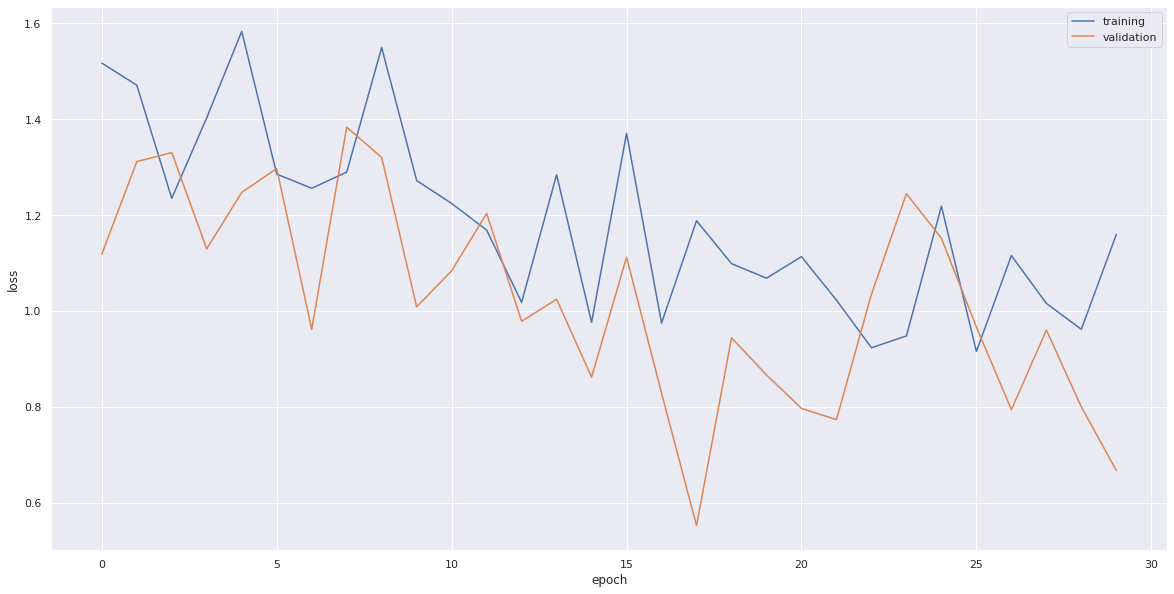

In [48]:
plotloss()

['cat', 'cat', 'cat', 'cat', 'cat', 'cat', 'cat', 'cat', 'cat', 'cat', 'cat', 'cat', 'cat', 'cat', 'cat', 'cat', 'cat', 'cat', 'cat', 'cat', 'cat', 'cat', 'cat', 'cat', 'cat', 'cat', 'cat', 'cat', 'cat', 'cat', 'cat', 'cat', 'cat', 'cat', 'cat', 'cat', 'cat', 'cat', 'cat', 'cat', 'cat', 'cat', 'cat', 'cat', 'cat', 'cat', 'cat', 'cat', 'cat', 'cat', 'cat', 'cat', 'cat', 'cat', 'cat', 'cat', 'cat', 'cat', 'cat', 'cat', 'cat', 'cat', 'cat', 'cat', 'cat', 'cat', 'cat', 'cat', 'cat', 'cat', 'cat', 'cat', 'cat', 'cat', 'cat', 'cat', 'cat', 'cat', 'cat', 'cat', 'cat', 'cat', 'cat', 'cat', 'cat', 'cat', 'cat', 'cat', 'cat', 'cat', 'cat', 'cat', 'cat', 'cat', 'cat', 'cat', 'cat', 'cat', 'cat', 'cat', 'cat', 'cat', 'cat', 'cat', 'cat', 'cat', 'cat', 'cat', 'cat', 'cat', 'cat', 'cat', 'cat', 'cat', 'cat', 'cat', 'cat', 'cat', 'cat', 'cat', 'cat', 'cat', 'cat', 'cow', 'cow', 'cow', 'cow', 'cow', 'cow', 'cow', 'cow', 'cow', 'cow', 'cow', 'cow', 'cow', 'cow', 'cow', 'cow', 'cow', 'cow', 'cow', 'cow'

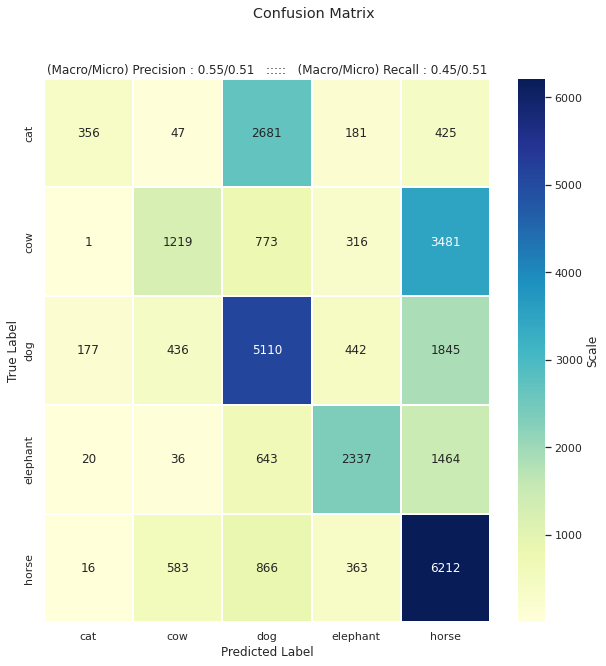

In [49]:
class2idx = {'cat': 0, 'cow': 1, 'dog': 2, 'elephant': 3, 'horse': 4}

idx2class = { value : key  for key , value in class2idx.items() }
y_true = [idx2class[val.item()] for val in y_expected_test ]
y_pred = [idx2class[val.item()] for val in y_test ]
print(y_true)
print(y_pred)

macro_precision = precision_score(y_true, y_pred, average="macro")
macro_recall = recall_score(y_true, y_pred, average="macro")
micro_precision = precision_score(y_true, y_pred, average="micro")
micro_recall = recall_score(y_true, y_pred, average="micro")
f1_score = (2*micro_precision*micro_recall)/(micro_recall + micro_precision)

print("f1 - Score is :--- " ,f1_score)
cnf_matrix = confusion_matrix(y_true , y_pred , labels=['cat','cow','dog','elephant','horse'])
plot_confusion_matrix(cnf_matrix , class2idx.keys() , [macro_precision , micro_precision , macro_recall , micro_recall], output_filename = "cnf_resnet_Data2.png")